In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
#instantiate mediapipe face mesh object and other required objects
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    min_detection_confidence=0.5, min_tracking_confidence=0.5
)

mp_drawing = mp.solutions.drawing_utils

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection

In [3]:
#Create bounding box around located face
def get_face_bbox(image, landmarks, margin=20):
    # Extract landmarks' x and y coordinates
    landmarks_x = [lm.x * image.shape[1] for lm in landmarks.landmark]
    landmarks_y = [lm.y * image.shape[0] for lm in landmarks.landmark]

    # Calculate the bounding box around the landmarks
    min_x = max(0, int(min(landmarks_x)) - margin)
    max_x = min(image.shape[1], int(max(landmarks_x)) + margin)
    min_y = max(0, int(min(landmarks_y)) - margin )
    max_y = min(image.shape[0], int(max(landmarks_y)) + margin )

    return min_x, min_y, max_x, max_y


In [4]:
def get_eye_openness(image):
    # Load the image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the results from the face mesh model
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]  # Assuming only one face is detected

        # Define eye region landmarks using MediaPipe's FaceMesh landmarks indices
        left_eye_indices = [246, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
        right_eye_indices = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]

        # Extract eye landmarks
        left_eye_landmarks = [landmarks.landmark[i] for i in left_eye_indices]
        right_eye_landmarks = [landmarks.landmark[i] for i in right_eye_indices]

        # Calculate the width and height of the detected face bounding box
        face_bbox = get_face_bbox(image, landmarks)
        face_width = face_bbox[2] - face_bbox[0]
        face_height = face_bbox[3] - face_bbox[1]

        # Normalize eye landmarks based on face size and scale for integer values
        scale_factor = 1000000  # You can adjust this scaling factor as needed
        left_eye_openness = int(abs(left_eye_landmarks[2].y - left_eye_landmarks[10].y) / face_height * scale_factor) # lm 159 -145
        right_eye_openness = int(abs(right_eye_landmarks[4].y - right_eye_landmarks[12].y) / face_height * scale_factor) # lm 386 - 374

        print("Left eye openness:", left_eye_openness, "Right eye openness:", right_eye_openness)

        # Determine eye openness
        if left_eye_openness > 150 and right_eye_openness > 150:
            eye_openness = "Open"
        elif left_eye_openness < 100 and right_eye_openness < 100:
            eye_openness = "Closed"
        else:
            eye_openness = "Semi-Open"

        print("Eye openness:", eye_openness)

        # Plot landmarks on the original loaded image
        for landmark in left_eye_landmarks:
            x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)  # Red circle for left eye landmarks
        for landmark in right_eye_landmarks:
            x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
            cv2.circle(image, (x, y), 1, (255, 0, 0), -1)  # Blue circle for right eye landmarks

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        return {"left_eye": left_eye_openness, "right_eye": right_eye_openness, "eye_openness": eye_openness}

    return "No face detected"

In [5]:
def detect_faces(image):
    # Load the face detection model from MediaPipe
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    # Convert the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    results = face_detection.process(image_rgb)

    return results

def get_prominent_face(image, results):
    if results.detections:
        # Find the most prominent face
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x, y, w, h = (
                int(bboxC.xmin * iw),
                int(bboxC.ymin * ih),
                int(bboxC.width * iw),
                int(bboxC.height * ih),
            )

            # Add a margin of 30 pixels around the face
            margin = 30
            x -= margin
            y -= margin
            w += 2 * margin
            h += 2 * margin

            # Ensure the cropped region is within the image boundaries
            x = max(x, 0)
            y = max(y, 0)
            w = min(w, iw - x)
            h = min(h, ih - y)

            # Crop the image to the detected face region
            cropped_face = image[y : y + h, x : x + w]

            cropped_face = cv2.resize(cropped_face, (255, 255))

            return cropped_face

    return None

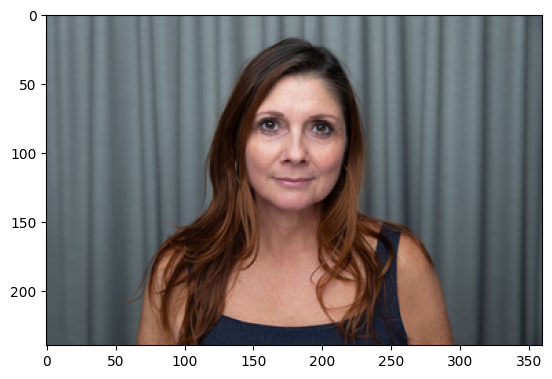

In [10]:
image_load = cv2.imread("Eye Openness 3/Open/Open2.jpg")

plt.imshow(cv2.cvtColor(image_load, cv2.COLOR_BGR2RGB))

Left eye openness: 200 Right eye openness: 187
Eye openness: Open


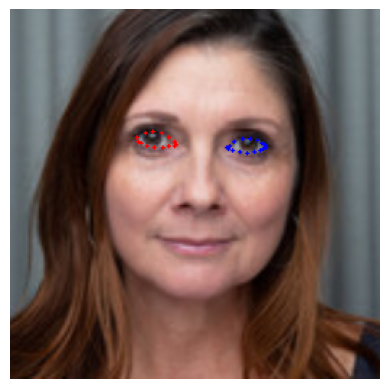

{'left_eye': 200, 'right_eye': 187, 'eye_openness': 'Open'}

In [11]:
image_load = get_prominent_face(image_load, detect_faces(image_load))
get_eye_openness(image_load)

In [28]:
#get the directory of testing data
testing_data_directory = "Eye Openness 3" 
#assign classes in array
classes = ["Closed", "Open", "Semi-Open"]


In [29]:
validation_result = []
file_comp = []

def get_eo_accuracy():
    for category in classes:
        path = os.path.join(testing_data_directory, category)
        class_category = classes.index(category) # angry, sad, happy, etc..
        
        for img_file in os.listdir(path):
            try:
                img_path = os.path.join(path, img_file)
                img_array = cv2.imread(img_path)
                
                face_detection = detect_faces(img_array)
                if face_detection is not None:
                    if face_detection is not None:
                        prominent_face = get_prominent_face(img_array, face_detection)
                        eye_openness = get_eye_openness(prominent_face)
                        left_eye_openness = eye_openness["left_eye"]
                        right_eye_openness = eye_openness["right_eye"]
                        eye_openness = eye_openness["eye_openness"]
                        print(img_file, ":", eye_openness)
                        validation_result.append([class_category, eye_openness])
                        file_comp.append([img_file, eye_openness, left_eye_openness, right_eye_openness])
                    else:
                        eye_openness = "No Face Detected"
                        validation_result.append([class_category, eye_openness])
                        file_comp.append([img_file, eye_openness])
                else:
                    print("Failed to load image:", img_file)
                    
            except Exception as e:
                print("Error processing image:", img_file, "Error:", str(e))


In [ ]:
get_eo_accuracy()

In [14]:
def calculate_accuracy(data_list):
    correct_prediction = 0
    incorrect_prediction = 0
    
    for item in data_list:
        true_label = item[0]
        predicted_label = item[1]
        
        if (true_label == 0 and predicted_label == 'Closed') or \
           (true_label == 1 and predicted_label == 'Open') or \
           (true_label == 2 and predicted_label == 'Semi-Open'):
            correct_prediction += 1
        else:
            incorrect_prediction += 1
    
    accuracy = correct_prediction / (correct_prediction + incorrect_prediction)
    print("The total number of data is " + str(len(data_list)))
    print("The number of correct predictions is: " + str(correct_prediction))
    print("The number of incorrect predictions is: " + str(incorrect_prediction))
    print("The accuracy of the model in the given dataset is: " + str(accuracy))

In [32]:
calculate_accuracy(validation_result)

The total number of data is 75
The number of correct predictions is: 42
The number of incorrect predictions is: 33
The accuracy of the model in the given dataset is: 0.56


In [19]:
def visualize_eye_landmarks(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the results from the face mesh model
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]  # Assuming only one face is detected

        # Define eye region landmarks using MediaPipe's FaceMesh landmarks indices
        left_eye_indices = [246, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
        right_eye_indices = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]

        # Extract eye landmarks
        left_eye_landmarks = [landmarks.landmark[i] for i in left_eye_indices]
        right_eye_landmarks = [landmarks.landmark[i] for i in right_eye_indices]

        # Visualize landmarks on the image
        for landmark in left_eye_landmarks + right_eye_landmarks:
            x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
            cv2.circle(image, (x, y), 1, (0, 255, 0), -1)  # Draw a circle at each landmark

        # Convert image to RGB for displaying with matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with landmarks using matplotlib
        plt.imshow(image_rgb)
        plt.show()

In [18]:
# Create a DataFrame from the validation results
df = pd.DataFrame(file_comp, columns=["Image Name", "Openness", "Left Eye", "Right Eye"])

folder_name = "CSVs"
# Specify the full path to the CSV file within the folder
csv_filename = os.path.join(folder_name, "MP_eo_validation1.csv")

# Save the DataFrame to a CSV file
df.to_csv(csv_filename, index=False)

print("Validation results saved to ", csv_filename)

Validation results saved to  CSVs\MP_eo_validation1.csv
